In [1]:
import pandas as pd
import numpy as np
import scipy
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm
from pathlib import Path

from celloracle import motif_analysis as ma
import celloracle as co
co.__version__


'0.20.0'

In [2]:

# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [ ]:
os.chdir('/home/kl467102/thesis/')
dataset_name = "pbmc10k"
ref_genome = 'hg38'
cluster_column = 'label'

include_hv_tfs = True
tfs_suffix = 'TFs' if include_hv_tfs else ''
n_top_genes = 2000
use_custom_grn = False
network_name = 'STRING12'

suffix = 'withATAC' if use_custom_grn else 'noATAC'
hvg_specific = f"{dataset_name}_{n_top_genes}{suffix}"
cicero_output = Path("results/cicero_output")  / dataset_name
celloracle_dir = Path("results/celloracle_output") / dataset_name
peaks_path = cicero_output / 'peak_gene_list.csv'
param_prefix = f"{dataset_name}_{network_name}_{n_top_genes}{tfs_suffix}"
adata_path = Path('BEELINE/inputs') /  f"{dataset_name}_{network_name}_{n_top_genes}{tfs_suffix}" / "adata.h5ad"
beeline_dir = '/home/kl467102/thesis/BEELINE/'
beeline_dir = Path(beeline_dir)
beeline_inputs_dir = beeline_dir / 'inputs' / dataset_name
beeline_outputs_dir = beeline_dir / 'outputs' / dataset_name


os.makedirs(celloracle_dir, exist_ok=True)
os.makedirs(celloracle_dir / hvg_specific, exist_ok=1)


## PROCESS

### 1. prepare input

#### gene expression


Make sure the data are subset to HVGs not only selected

In [4]:
# Load data.
preprocessed_adata = sc.read_h5ad(adata_path)


In [5]:
print(f"Cell number is :{preprocessed_adata.shape[0]}")
print(f"Gene number is :{preprocessed_adata.shape[1]}")
# Check data in anndata
print("Metadata columns :", list(preprocessed_adata.obs.columns))
print("Dimensional reduction: ", list(preprocessed_adata.obsm.keys()))

Cell number is :11474
Gene number is :19435
Metadata columns : ['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'label', 'leiden']
Dimensional reduction:  ['X_pca', 'X_umap']


In [6]:
adata = preprocessed_adata.copy()
# Select highly variable genes and SUBSET
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, subset=True)

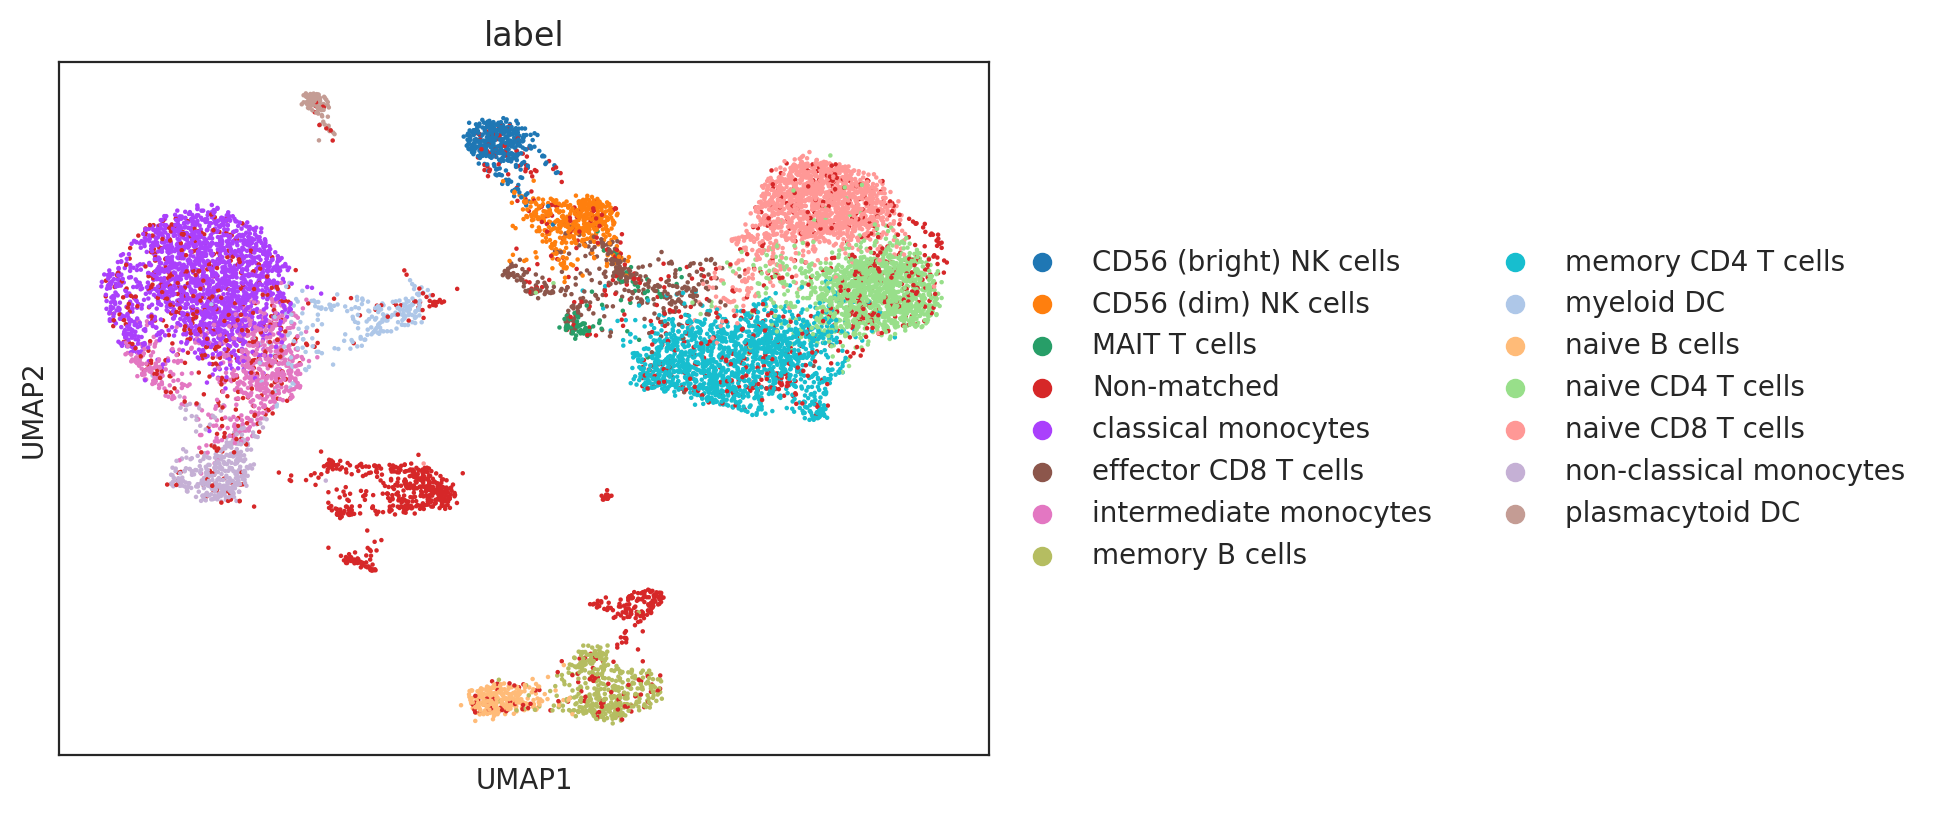

In [7]:
embedding = "X_umap"
clustering = cluster_column
# Visualize
if embedding == "X_draw_graph_fa":
    sc.pl.draw_graph(adata, color=clustering)

elif embedding == "X_umap":
    sc.pl.umap(adata, color=clustering)
    
elif embedding == "X_tsne":
    sc.pl.tsne(adata, color=clustering)

#### TFInfo

In [8]:
if ref_genome == 'hg38':
    version = 'hg38_gimmemotifsv5_fpr2'
elif ref_genome == 'hg19':
    version = 'hg19_gimmemotifsv5_fpr2'
else:
    print('oopsie')
if use_custom_grn:
    tf_df = pd.read_parquet(celloracle_dir / 'tfinfo.parquet')
else:
    tf_df = co.data.load_human_promoter_base_GRN(version = version)


tf_df.head()

Loading prebuilt promoter base-GRN. Version: hg38_gimmemotifsv5_fpr2


,peak_id,gene_short_name,9430076C15RIK,AC002126.6,AC012531.1,AC226150.2,AFP,AHR,AHRR,AIRE,...,ZNF784,ZNF8,ZNF816,ZNF85,ZSCAN10,ZSCAN16,ZSCAN22,ZSCAN26,ZSCAN31,ZSCAN4
0,chr10_100009853_100010953,DNMBP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_100081785_100082885,CPN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,chr10_100185877_100186977,ERLIN1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_100186978_100187057,ERLIN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_100229510_100230610,CHUK,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. initiate celloracle object

In [9]:
oracle = co.Oracle()


#### import raw counts into CO

In [10]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["counts"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name=cluster_column,
                                   embedding_name="X_umap")


In [11]:
# Print the minimum, maximum, and a few example values
print(f"Min value: {adata.X.min()}")
print(f"Max value: {adata.X.max()}")

# Use .toarray() in case adata.X is a sparse matrix
print("A few example values:")
print(adata.X[:50, :50].toarray())

Min value: 0.0
Max value: 4165.0
A few example values:
[[0. 0. 0. ... 2. 0. 3.]
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 3. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


#### load base grn from step 3

In [12]:
oracle.import_TF_data(TF_info_matrix=tf_df)


### 3. PCA, KNN

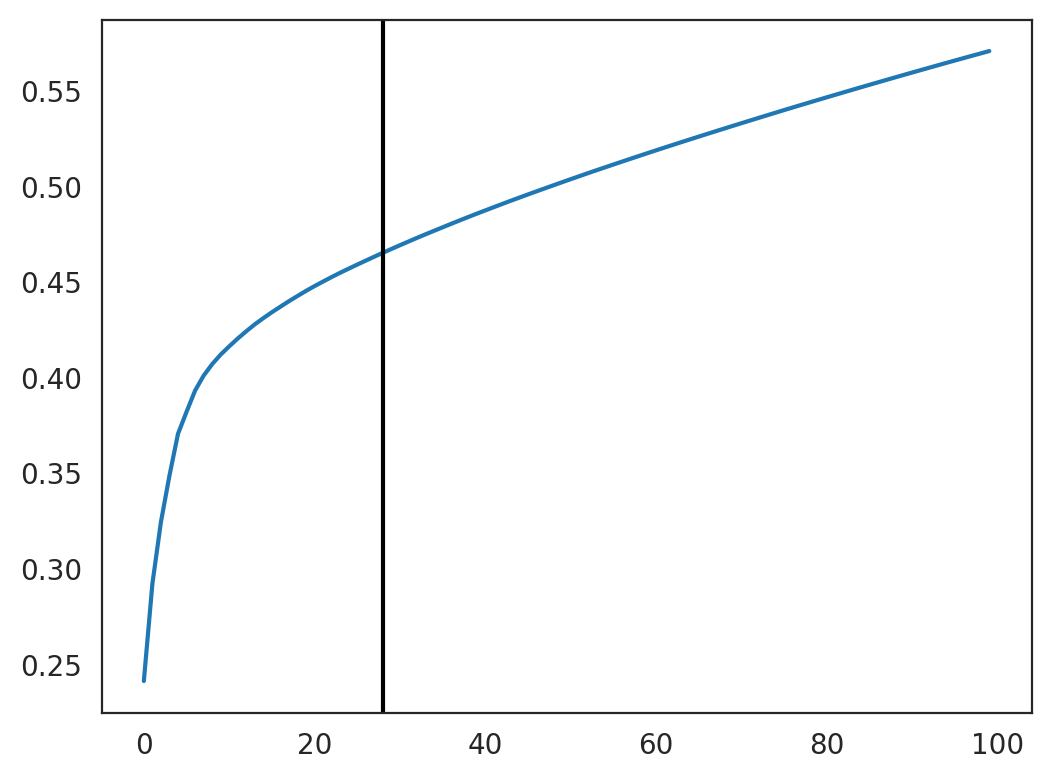

28


In [13]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)

In [14]:
n_comps = min(n_comps, 50)

In [15]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :11474
Auto-selected k is :286


In [16]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=16)


### 4. save and load

In [17]:
oracled_path = celloracle_dir / hvg_specific / "oracle.celloracle.oracle"
oracled_path = str(oracled_path)

In [18]:
oracle.to_hdf5(oracled_path)

In [19]:
oracle = co.load_hdf5(oracled_path)

In [20]:
oracle.adata

AnnData object with n_obs × n_vars = 11474 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'label', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
    uns: 'hvg', 'label_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


### 5. GRN calculation

In [ ]:
%%time
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit=cluster_column, alpha=10,
                         verbose_level=10)


  0%|          | 0/15 [00:00<?, ?it/s]

Inferring GRN for CD56 (bright) NK cells...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for CD56 (dim) NK cells...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for MAIT T cells...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for Non-matched...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for classical monocytes...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for effector CD8 T cells...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for intermediate monocytes...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for memory B cells...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for memory CD4 T cells...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for myeloid DC...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for naive B cells...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for naive CD4 T cells...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for naive CD8 T cells...


  0%|          | 0/1578 [00:00<?, ?it/s]

Inferring GRN for non-classical monocytes...


  0%|          | 0/1578 [00:00<?, ?it/s]

In [ ]:
links.links_dict.keys()

dict_keys(['CD56 (bright) NK cells', 'CD56 (dim) NK cells', 'MAIT T cells', 'Non-matched', 'classical monocytes', 'effector CD8 T cells', 'intermediate monocytes', 'memory B cells', 'memory CD4 T cells', 'myeloid DC', 'naive B cells', 'naive CD4 T cells', 'naive CD8 T cells', 'non-classical monocytes', 'plasmacytoid DC'])

In [ ]:
links_path = celloracle_dir / hvg_specific / "links.celloracle.links"
links_path = str(links_path)
links.to_hdf5(file_path = links_path)
links_o = co.load_hdf5(links_path)


In [ ]:
grns_path = celloracle_dir / hvg_specific  / 'grns'
os.makedirs(grns_path, exist_ok=1)
grns_path

PosixPath('results/celloracle_output/pbmc10k/pbmc10k_2000/grns_includeATAC')

In [ ]:
for key in links.links_dict.keys():
    links.links_dict[key].to_csv(f"{grns_path}/raw_GRN_for_{key}.csv")


In [ ]:
from pathlib import Path

directory = Path(grns_path)
files = [f for f in directory.iterdir() if f.is_file()]
df = pd.concat([pd.read_csv(f, index_col=0) for f in files], ignore_index=True)
mask = df.p<0.05
df = df[mask]
df = df[~(df.coef_abs==0)] 
df = df.loc[df.groupby(['source', 'target'])['coef_abs'].idxmax()]
df = df[['source', 'target', 'coef_abs'] ]
df.sort_values(by='coef_abs', inplace=True, ascending = False)
df.reset_index(drop=True, inplace=True)
df.columns = ['Gene1','Gene2','EdgeWeight']
df.to_csv(celloracle_dir / hvg_specific / "rankedEdges.csv", index=False, sep = '\t')




In [22]:
method_name= 'CellOracle_withATAC' if use_custom_grn else 'CellOracle_noATAC'
df.to_csv(param_prefix / method_name / "rankedEdges.csv", index=False, sep = '\t')


NameError: name 'df' is not defined